## 1. Imports & chargement


In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [2]:
# imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# config et chemins
cfg_path = Path("config.yaml")
import yaml
cfg = yaml.safe_load(open(cfg_path))
inter_dir = Path(cfg["paths"]["data"]["interim"])
processed_dir = Path(cfg["paths"]["data"]["processed"])
processed_dir.mkdir(parents=True, exist_ok=True)

# liste des zones
zones = [p.stem.replace("_interim_hourly","")
         for p in inter_dir.glob("*_interim_hourly.pkl")]


In [3]:
print(zones)

['Baleares', 'Canarias', 'Ceuta', 'El_Hierro', 'Gran_canaria', 'Lanzarote_Fuerteventura', 'La_Gomera', 'La_Palma', 'Melilla', 'nacional', 'Peninsule_Iberique', 'Tenerife']


## 2. Degrés-jours (HDD/CDD)

In [4]:
# fonctions HDD / CDD
def add_degree_days(df, base_temp=18.0):
    df["HDD"] = np.maximum(0, base_temp - df["temperature_2m"])
    df["CDD"] = np.maximum(0, df["temperature_2m"] - base_temp)
    return df


## 3. Indices de confort

In [5]:
def compute_heat_index(T, RH):
    # formule simplifiée de Rothfusz (approx)
    return -8.7847 + 1.6114*T + 2.3385*RH - 0.1461*T*RH \
           - 0.0123*T**2 - 0.0164*RH**2 + 0.0022*T**2*RH \
           + 0.0007*T*RH**2 - 0.0000*T**2*RH**2

def add_comfort_indices(df):
    df["HeatIndex"] = compute_heat_index(df["temperature_2m"],
                                         df["relative_humidity_2m"])
    # Wind Chill si T<=10°C et vent>4.8km/h (conversion m/s→km/h*)
    v_kmh = df["wind_speed_10m"] * 3.6
    df["WindChill"] = np.where(
        (df["temperature_2m"] <= 10) & (v_kmh > 4.8),
        13.12 + 0.6215*df["temperature_2m"] - 11.37*v_kmh**0.16
        + 0.3965*df["temperature_2m"]*v_kmh**0.16,
        df["temperature_2m"]
    )
    return df


## 4. Fenêtres glissantes météo et prix

In [6]:
# rolling windows pour variables clés
def add_rolling_features(df):
    windows = [3, 6, 12, 24, 7, 14, 30, 365]  # en heures ou jours
    for w in windows:
        df[f"temp_rmean_{w}"] = df["temperature_2m"].rolling(w).mean()
        df[f"pvpc_rmean_{w}"] = df["pvpc"].rolling(w).mean()
        df[f"rad_rsum_{w}"]   = df["shortwave_radiation"].rolling(w).sum()
    # quelques lags supplémentaires déjà en 02, on peut en ajouter
    return df


## 5. Encodages cycliques et calendaires

In [7]:
# encodages cycliques et saisons
def add_cyclic_time_features(df):
    idx = df.index
    df["hour"]    = idx.hour
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

    df["dayofweek"]  = idx.dayofweek
    df["dow_sin"]    = np.sin(2*np.pi*df["dayofweek"]/7)
    df["dow_cos"]    = np.cos(2*np.pi*df["dayofweek"]/7)

    df["month"]   = idx.month
    df["mth_sin"] = np.sin(2*np.pi*(df["month"]-1)/12)
    df["mth_cos"] = np.cos(2*np.pi*(df["month"]-1)/12)

    df["season"] = ((idx.month % 12 + 3)//3).astype(int)  # 1=hiver,2=printemps…
    return df


## 6. Interactions et transformations non linéaires

In [8]:
# interactions supplémentaires
def add_interactions(df):
    # Interaction entre température et humidité relative
    df["T_x_RH"] = df["temperature_2m"] * df["relative_humidity_2m"]
    
    # Carré de la température
    df["T_sq"] = df["temperature_2m"] ** 2
    
    # Interaction entre prix PVPC et température
    df["pvpc_x_T"] = df["pvpc"] * df["temperature_2m"]
    
    # Interaction entre radiation solaire et température
    if "shortwave_radiation" in df.columns:
        df["rad_x_T"] = df["shortwave_radiation"] * df["temperature_2m"]
    
    # Interaction entre radiation solaire et humidité relative
    if "shortwave_radiation" in df.columns:
        df["rad_x_RH"] = df["shortwave_radiation"] * df["relative_humidity_2m"]
    
    # Interaction entre vitesse du vent et température
    if "wind_speed_10m" in df.columns:
        df["wind_x_T"] = df["wind_speed_10m"] * df["temperature_2m"]
    
    # Interaction entre vitesse du vent et humidité relative
    if "wind_speed_10m" in df.columns:
        df["wind_x_RH"] = df["wind_speed_10m"] * df["relative_humidity_2m"]
    
    # Interaction entre radiation solaire et prix PVPC
    if "shortwave_radiation" in df.columns:
        df["rad_x_pvpc"] = df["shortwave_radiation"] * df["pvpc"]
    
    return df


## 7. Sélection de features

In [9]:
# mutual information et importance simple
def select_features(df, target="demand", top_k=20):
    X = df.drop(columns=[target]).fillna(0)
    y = df[target].values
    mi = mutual_info_regression(X, y, discrete_features=False)
    mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    return mi_s.head(top_k)



lag_1h            1.601950
lag_24h           1.533232
lag_168h          1.195095
lag_2h            0.994679
lag_3h            0.683009
lag_4h            0.513179
dayofyear         0.471847
rmean_7d          0.433811
lag_5h            0.429332
temperature_2m    0.425091
dtype: float64

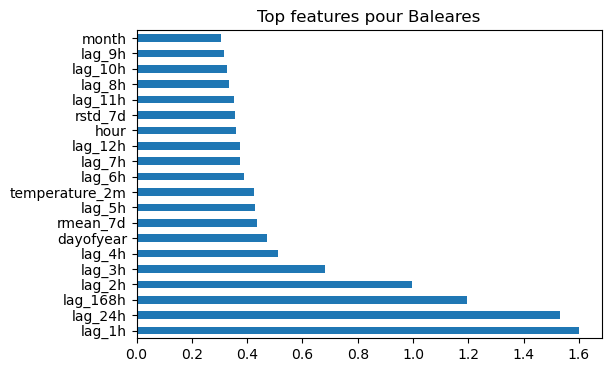

In [10]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_hourly.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

lag_1d            1.311973
rmean_7d          0.993811
lag_2d            0.925059
lag_7d            0.902139
lag_3d            0.889850
lag_6d            0.827827
lag_4d            0.812853
temperature_2m    0.782237
lag_5d            0.778742
lag_365d          0.569301
dtype: float64

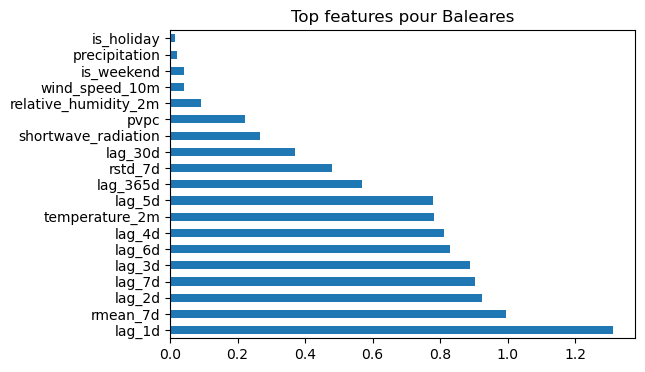

In [11]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_daily.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

## 8. Boucle complète et export final

In [18]:
# pipeline feature engineering et sauvegarde processed
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_hourly.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    # on peut garder les features de la liste ci-dessous
    features_to_keep = ["demand", "lag_1h", "lag_2h", "lag_3h", "lag_4h", "lag_6h", "lag_12h", "lag_24h"]
    features_to_keep += select_features(df, top_k= 11).index.tolist() 

    features_to_keep = list(set(features_to_keep))

    # on ne garde que les features sélectionnées
    df_e = df[features_to_keep]["2018-01-01":"2024-01-02"]
    df_s = df.loc["2017-01-02":, ["demand"]]

    # Export final en Parquet
    out_path_e = processed_dir/f"{zone}_processed_hourly.parquet"
    out_path_s = processed_dir/".."/"submission"/f"{zone}_processed_daily.parquet"
    df_e.to_parquet(out_path_e, index=True)
    df_s.to_parquet(out_path_s, index=True)
    print(f"   • saved {out_path_e.name}")


→ Feature engineering Baleares
   • saved Baleares_processed_hourly.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_hourly.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_hourly.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_hourly.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_hourly.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_hourly.parquet
→ Feature engineering La_Gomera
   • saved La_Gomera_processed_hourly.parquet
→ Feature engineering La_Palma
   • saved La_Palma_processed_hourly.parquet
→ Feature engineering Melilla
   • saved Melilla_processed_hourly.parquet
→ Feature engineering nacional
   • saved nacional_processed_hourly.parquet
→ Feature engineering Peninsule_Iberique
   • saved Peninsule_Iberique_processed_hourly.parquet
→ Feature engineering Tenerife
   • saved Tenerife_processed_hourly.parquet


In [20]:
# pipeline feature engineering et sauvegarde processed
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_daily.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    # on peut garder les features de la liste ci-dessous
    features_to_keep = ["demand", "lag_1d", "lag_2d", "lag_3d", "lag_7d", "lag_30d"]
    features_to_keep += select_features(df, top_k= 11).index.tolist() 

    features_to_keep = list(set(features_to_keep))

    # on ne garde que les features sélectionnées
    df_e = df[features_to_keep][:"2024-01-02"]
    df_s = df.loc["2017-01-02":, ["demand"]]

    # Export final en Parquet
    out_path_e = processed_dir/f"{zone}_processed_daily.parquet"
    out_path_s = processed_dir/".."/"submission"/f"{zone}_processed_hourly.parquet"
    
    df_e.to_parquet(out_path_e, index=True)
    df_s.to_parquet(out_path_s, index=True)
    print(f"   • saved {out_path_e.name}")


→ Feature engineering Baleares
   • saved Baleares_processed_daily.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_daily.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_daily.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_daily.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_daily.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_daily.parquet
→ Feature engineering La_Gomera
   • saved La_Gomera_processed_daily.parquet
→ Feature engineering La_Palma
   • saved La_Palma_processed_daily.parquet
→ Feature engineering Melilla
   • saved Melilla_processed_daily.parquet
→ Feature engineering nacional
   • saved nacional_processed_daily.parquet
→ Feature engineering Peninsule_Iberique
   • saved Peninsule_Iberique_processed_daily.parquet
→ Feature engineering Tenerife
   • saved Tenerife_processed_daily.parquet


,temp_rmean_6,demand,rmean_7d,temp_rmean_12,temp_rmean_14,lag_365d,lag_7d,lag_1d,temp_rmean_7,temp_rmean_24,temp_rmean_3,month,lag_30d,lag_3d,lag_2d
datetime,,,,,,,,,,,,,,,
2019-12-28 00:00:00+00:00,3.955556,7724400.0,7.502970e+06,3.850694,4.152381,1483447.0,7895162.0,8083982.0,3.575000,4.250174,4.587500,12,9278212.0,6428639.0,7514956.0
2019-12-29 00:00:00+00:00,3.955556,7388000.0,7.507612e+06,3.850694,4.152381,8118029.0,7355505.0,7724400.0,3.575000,4.250174,4.587500,12,8812232.0,7514956.0,8083982.0
2019-12-30 00:00:00+00:00,3.955556,7982822.0,7.498337e+06,3.850694,4.152381,1713458.0,8047746.0,7388000.0,3.575000,4.250174,4.587500,12,309163.0,8083982.0,7724400.0
2019-12-31 00:00:00+00:00,3.955556,293892.0,6.488099e+06,3.850694,4.152381,298764.0,7365562.0,7982822.0,3.575000,4.250174,4.087500,12,7734099.0,7724400.0,7388000.0
2020-01-01 00:00:00+00:00,3.955556,6983011.0,6.567295e+06,3.850694,4.152381,7064893.0,6428639.0,293892.0,3.575000,4.250174,3.756944,1,9186035.0,7388000.0,7982822.0
2020-01-02 00:00:00+00:00,3.955556,8744941.0,6.743007e+06,3.850694,4.152381,8999268.0,7514956.0,6983011.0,3.575000,4.250174,3.323611,1,9453238.0,7982822.0,293892.0
2020-01-03 00:00:00+00:00,3.223611,9057922.0,6.882141e+06,3.850694,4.152381,9497947.0,8083982.0,8744941.0,3.575000,4.250174,2.359722,1,9566003.0,293892.0,6983011.0
2020-01-04 00:00:00+00:00,3.265278,8341057.0,6.970235e+06,3.850694,4.152381,9560597.0,7724400.0,9057922.0,3.404762,4.250174,2.773611,1,9466549.0,6983011.0,8744941.0
2020-01-05 00:00:00+00:00,3.275694,7887749.0,7.041628e+06,3.850694,4.152381,8653012.0,7388000.0,8341057.0,3.355952,4.250174,3.227778,1,8260808.0,8744941.0,9057922.0


lag_1d           0.773504
lag_7d           0.549050
rmean_7d         0.439785
temp_rmean_12    0.401906
temp_rmean_14    0.390870
temp_rmean_6     0.382460
temp_rmean_7     0.357881
temp_rmean_24    0.350880
temp_rmean_3     0.339840
month            0.325728
dtype: float64

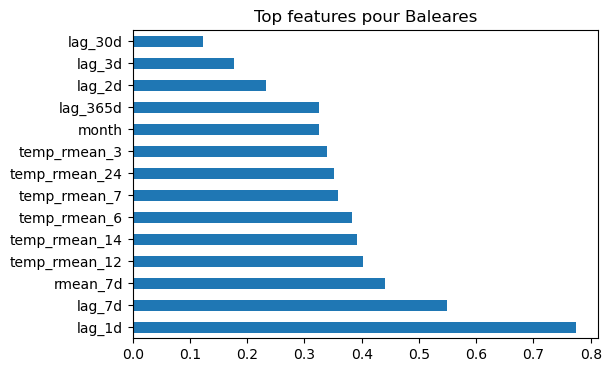

In [22]:
# Exemple d’affichage pour la première zone
df = pd.read_parquet(processed_dir/f"{zones[9]}_processed_daily.parquet")
mi_top = select_features(df)

display(df.head(10))
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

,lag_4h,lag_1h,demand,rmean_7d,temperature_2m,lag_12h,lag_5h,WindChill,lag_24h,dayofyear,lag_6h,lag_168h,lag_3h,lag_2h
datetime,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.000,498.880,475.352,495.258690,14.7,0.0,0.000,14.7,0.0,1,0.000,486.743,0.000,0.000
2018-01-01 01:00:00+00:00,0.000,475.352,446.327,495.265452,15.2,0.0,0.000,15.2,0.0,1,0.000,445.191,0.000,498.880
2018-01-01 02:00:00+00:00,0.000,446.327,417.487,495.288845,13.9,0.0,0.000,13.9,0.0,1,0.000,413.557,498.880,475.352
2018-01-01 03:00:00+00:00,498.880,417.487,398.361,495.308440,13.4,0.0,0.000,13.4,0.0,1,0.000,395.069,475.352,446.327
2018-01-01 04:00:00+00:00,475.352,398.361,391.095,495.300774,13.0,0.0,498.880,13.0,0.0,1,0.000,392.383,446.327,417.487
2018-01-01 05:00:00+00:00,446.327,391.095,397.352,495.249571,12.8,0.0,475.352,12.8,0.0,1,498.880,405.954,417.487,398.361
2018-01-01 06:00:00+00:00,417.487,397.352,408.544,495.158798,12.7,0.0,446.327,12.7,0.0,1,475.352,423.794,398.361,391.095
2018-01-01 07:00:00+00:00,398.361,408.544,413.580,494.963339,12.5,0.0,417.487,12.5,0.0,1,446.327,446.417,391.095,397.352
2018-01-01 08:00:00+00:00,391.095,413.580,451.715,494.588250,12.7,0.0,398.361,12.7,0.0,1,417.487,514.730,397.352,408.544


lag_1h       1.632107
lag_24h      1.570963
lag_168h     1.212234
lag_2h       1.020426
lag_3h       0.713657
lag_4h       0.539862
dayofyear    0.482351
rmean_7d     0.462795
lag_5h       0.451881
WindChill    0.412328
dtype: float64

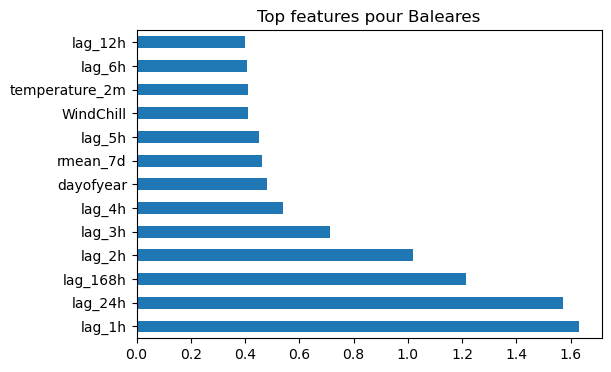

In [23]:
# Exemple d’affichage pour la première zone
df = pd.read_parquet(processed_dir/f"{zones[0]}_processed_hourly.parquet")
mi_top = select_features(df)

display(df.head(10))
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()